Kemas Veriandra Ramadhan

122450016

RA

MODUL 9 DEEP LEARNING

# Percobaan 1: Vanilla GAN untuk 2D Gaussian

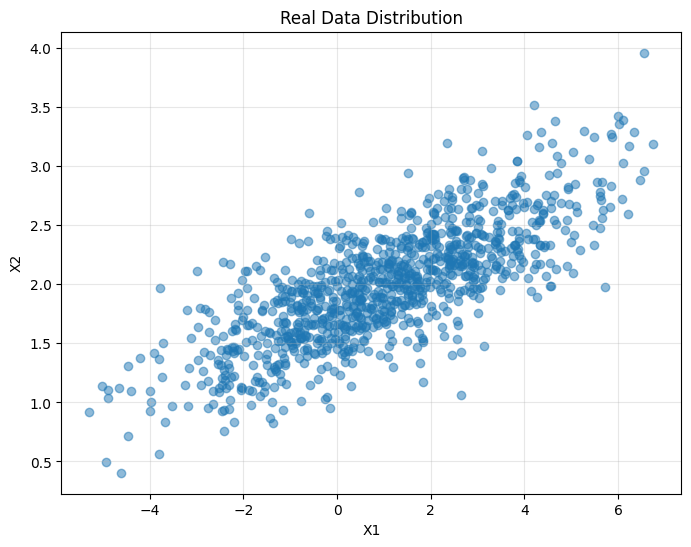

Mean: [1.02759235 1.99145847]
Covariance:
[[4.90612958 0.84914045]
 [0.84914045 0.24584549]]
Starting GAN training...
Epoch 5/50 - Loss D: 1.0139, Loss G: 1.0653
Epoch 10/50 - Loss D: 1.2719, Loss G: 0.8218
Epoch 15/50 - Loss D: 1.3306, Loss G: 0.7495
Epoch 20/50 - Loss D: 1.3752, Loss G: 0.7199
Epoch 25/50 - Loss D: 1.3758, Loss G: 0.7043
Epoch 30/50 - Loss D: 1.3862, Loss G: 0.6975
Epoch 35/50 - Loss D: 1.3824, Loss G: 0.6950
Epoch 40/50 - Loss D: 1.3872, Loss G: 0.6947
Epoch 45/50 - Loss D: 1.3860, Loss G: 0.6935
Epoch 50/50 - Loss D: 1.3870, Loss G: 0.6943


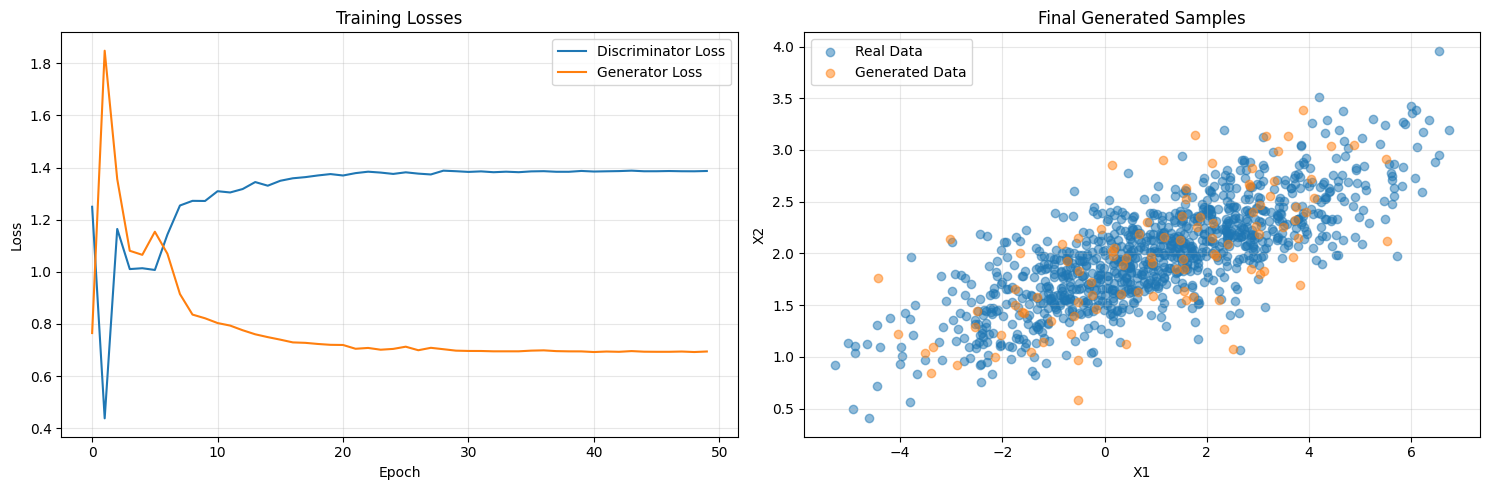

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Generate real data from 2D Gaussian
def generate_real_data(n_samples=1000):
    """Generate real data from 2D Gaussian distribution"""
    X = np.random.randn(n_samples, 2)
    # Apply linear transformation
    A = np.array([[1, 2], [-0.1, 0.5]])
    b = np.array([1, 2])
    data = X @ A.T + b
    return data

# Visualize data distribution
real_data = generate_real_data(1000)

plt.figure(figsize=(8, 6))
plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.5)
plt.title('Real Data Distribution')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True, alpha=0.3)
plt.savefig('real_data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute statistics
mean = np.mean(real_data, axis=0)
cov = np.cov(real_data.T)
print(f"Mean: {mean}")
print(f"Covariance:\n{cov}")


class Generator:
    """Simple generator network"""
    def __init__(self, input_dim=2, output_dim=2):
        self.W = np.random.randn(input_dim, output_dim) * 0.1
        self.b = np.zeros(output_dim)
    
    def forward(self, z):
        """Generate fake samples"""
        return z @ self.W + self.b
    
    def backward(self, z, grad_output):
        """Compute gradients"""
        grad_W = z.T @ grad_output
        grad_b = np.sum(grad_output, axis=0)
        return grad_W, grad_b
    
    def update(self, grad_W, grad_b, lr):
        """Update parameters"""
        self.W -= lr * grad_W
        self.b -= lr * grad_b


class Discriminator:
    """Simple discriminator network with 3 layers"""
    def __init__(self, input_dim=2, hidden_dims=[5, 3]):
        self.W1 = np.random.randn(input_dim, hidden_dims[0]) * 0.1
        self.b1 = np.zeros(hidden_dims[0])
        self.W2 = np.random.randn(hidden_dims[0], hidden_dims[1]) * 0.1
        self.b2 = np.zeros(hidden_dims[1])
        self.W3 = np.random.randn(hidden_dims[1], 1) * 0.1
        self.b3 = np.zeros(1)
        # Cache for backpropagation
        self.cache = {}
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward(self, x):
        """Forward pass"""
        # Layer 1
        z1 = x @ self.W1 + self.b1
        a1 = self.tanh(z1)
        # Layer 2
        z2 = a1 @ self.W2 + self.b2
        a2 = self.tanh(z2)
        # Layer 3
        z3 = a2 @ self.W3 + self.b3
        a3 = self.sigmoid(z3)
        # Cache for backward pass
        self.cache = {
            'x': x, 'z1': z1, 'a1': a1,
            'z2': z2, 'a2': a2, 'z3': z3, 'a3': a3
        }
        return a3
    
    def backward(self, grad_output):
        """Backward pass"""
        # Retrieve cached values
        x = self.cache['x']
        a1 = self.cache['a1']
        a2 = self.cache['a2']
        z1 = self.cache['z1']
        z2 = self.cache['z2']
        z3 = self.cache['z3']
        
        # Layer 3 gradients
        dz3 = grad_output * self.sigmoid(z3) * (1 - self.sigmoid(z3))
        dW3 = a2.T @ dz3
        db3 = np.sum(dz3, axis=0)
        
        # Layer 2 gradients
        da2 = dz3 @ self.W3.T
        dz2 = da2 * self.tanh_derivative(z2)
        dW2 = a1.T @ dz2
        db2 = np.sum(dz2, axis=0)
        
        # Layer 1 gradients
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.tanh_derivative(z1)
        dW1 = x.T @ dz1
        db1 = np.sum(dz1, axis=0)
        
        # Gradient for input (for generator training)
        dx = dz1 @ self.W1.T
        
        return {
            'dW1': dW1, 'db1': db1,
            'dW2': dW2, 'db2': db2,
            'dW3': dW3, 'db3': db3,
            'dx': dx
        }
    
    def update(self, grads, lr):
        """Update parameters"""
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']
        self.W3 -= lr * grads['dW3']
        self.b3 -= lr * grads['db3']


def train_gan(generator, discriminator, real_data,
              n_epochs=20, batch_size=8, lr_g=0.005, lr_d=0.05):
    """Train GAN"""
    n_samples = len(real_data)
    n_batches = n_samples // batch_size
    
    history = {
        'loss_d': [],
        'loss_g': [],
        'fake_samples': []
    }
    
    print("Starting GAN training...")
    
    for epoch in range(n_epochs):
        # Shuffle data
        indices = np.random.permutation(n_samples)
        real_data_shuffled = real_data[indices]
        
        epoch_loss_d = 0
        epoch_loss_g = 0
        
        for batch in range(n_batches):
            # Get batch of real data
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            real_batch = real_data_shuffled[start_idx:end_idx]
            
            # Generate fake data
            z = np.random.randn(batch_size, 2)
            fake_batch = generator.forward(z)
            
            # Train Discriminator
            # Forward pass for real and fake data
            d_real = discriminator.forward(real_batch)
            d_fake = discriminator.forward(fake_batch)
            
            # Discriminator loss: maximize log(D(x)) + log(1 - D(G(z)))
            loss_d = -np.mean(np.log(d_real + 1e-8) + np.log(1 - d_fake + 1e-8))
            
            # Backward pass for discriminator (on real data)
            grad_d_real = -(1 / (d_real + 1e-8)) / batch_size
            discriminator.forward(real_batch)  # Re-cache
            grads_real = discriminator.backward(grad_d_real)
            
            # Backward pass for discriminator (on fake data)
            grad_d_fake_disc = (1 / (1 - d_fake + 1e-8)) / batch_size
            discriminator.forward(fake_batch)  # Re-cache
            grads_fake = discriminator.backward(grad_d_fake_disc)
            
            # Combine gradients and update discriminator
            combined_grads = {
                'dW1': grads_real['dW1'] + grads_fake['dW1'],
                'db1': grads_real['db1'] + grads_fake['db1'],
                'dW2': grads_real['dW2'] + grads_fake['dW2'],
                'db2': grads_real['db2'] + grads_fake['db2'],
                'dW3': grads_real['dW3'] + grads_fake['dW3'],
                'db3': grads_real['db3'] + grads_fake['db3'],
            }
            discriminator.update(combined_grads, lr_d)
            
            # Train Generator
            # Generate new fake data
            z = np.random.randn(batch_size, 2)
            fake_batch = generator.forward(z)
            d_fake = discriminator.forward(fake_batch)
            
            # Generator loss: maximize log(D(G(z)))
            loss_g = -np.mean(np.log(d_fake + 1e-8))
            
            # Backward pass for generator
            grad_d_fake = -(1 / (d_fake + 1e-8)) / batch_size
            grads_d = discriminator.backward(grad_d_fake)
            
            # Gradient through generator
            grad_fake_batch = grads_d['dx']
            grad_W, grad_b = generator.backward(z, grad_fake_batch)
            
            # Update generator
            generator.update(grad_W, grad_b, lr_g)
            
            epoch_loss_d += loss_d
            epoch_loss_g += loss_g
        
        # Average losses
        epoch_loss_d /= n_batches
        epoch_loss_g /= n_batches
        
        history['loss_d'].append(epoch_loss_d)
        history['loss_g'].append(epoch_loss_g)
        
        # Generate samples for visualization
        z = np.random.randn(100, 2)
        fake_samples = generator.forward(z)
        history['fake_samples'].append(fake_samples.copy())
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} - "
                  f"Loss D: {epoch_loss_d:.4f}, Loss G: {epoch_loss_g:.4f}")
    
    return history


# Initialize networks
generator = Generator(input_dim=2, output_dim=2)
discriminator = Discriminator(input_dim=2, hidden_dims=[5, 3])

# Train GAN
history = train_gan(generator, discriminator, real_data,
                    n_epochs=50, batch_size=8, lr_g=0.005, lr_d=0.05)

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['loss_d'], label='Discriminator Loss')
axes[0].plot(history['loss_g'], label='Generator Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Losses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Final generated samples
fake_samples = history['fake_samples'][-1]
axes[1].scatter(real_data[:, 0], real_data[:, 1],
                alpha=0.5, label='Real Data')
axes[1].scatter(fake_samples[:, 0], fake_samples[:, 1],
                alpha=0.5, label='Generated Data')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')
axes[1].set_title('Final Generated Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Create animation of training process
fig, ax = plt.subplots(figsize=(8, 6))

def animate(frame):
    ax.clear()
    ax.scatter(real_data[:, 0], real_data[:, 1],
               alpha=0.3, label='Real Data', s=20)
    if frame < len(history['fake_samples']):
        fake = history['fake_samples'][frame]
        ax.scatter(fake[:, 0], fake[:, 1],
                   alpha=0.5, label='Generated Data', s=20)
    ax.set_xlim(-4, 6)
    ax.set_ylim(-2, 6)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(f'GAN Training Progress - Epoch {frame+1}')
    ax.legend()
    ax.grid(True, alpha=0.3)

anim = FuncAnimation(fig, animate, frames=len(history['fake_samples']),
                     interval=500, repeat=True)
plt.close()

# Display animation
HTML(anim.to_jshtml())


# 3.2 Percobaan 2: DCGAN untuk Image Generation (MNIST)



Loading MNIST dataset...
Dataset shape: (70000, 28, 28, 1)
Value range: [-1.00, 1.00]


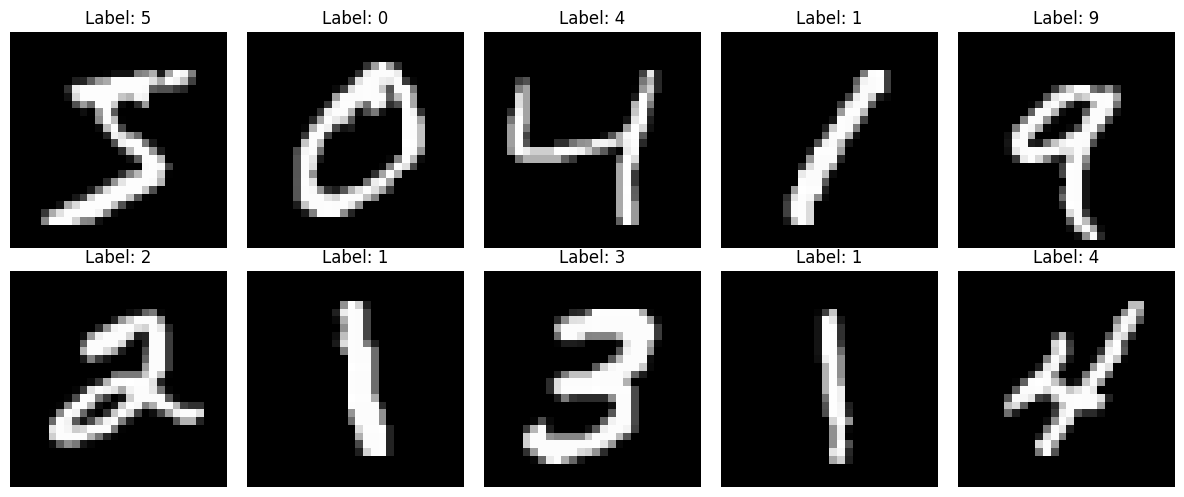

Generated images shape: (4, 1, 56, 56)
Value range: [-0.01, 0.02]

Generator Architecture:
Input: z ∈ R^100
FC Layer: 100 -> 128×7×7
TransConv1 + BN + ReLU: 128×7×7 -> 64×14×14
TransConv2 + BN + ReLU: 64×14×14 -> 32×28×28
TransConv3 + Tanh: 32×28×28 -> 1×28×28

Discriminator output for real images: [0.49408535 0.49470581 0.50009679 0.49602165]
Discriminator output for fake images: [0.50001799 0.50000285 0.50000675 0.49999559 0.49999599 0.50002624
 0.50002162 0.50001306 0.50000059 0.50001615 0.50000737 0.50000734
 0.50001597 0.50000865 0.50000506 0.5000021  0.49999664 0.50001648
 0.50000416 0.50000352 0.499989   0.50000775 0.49999165 0.50000034
 0.50001871 0.50000041 0.50000901 0.49999775 0.4999956  0.50000618
 0.50001624 0.50001081 0.50000752 0.5000164  0.50001862 0.50000266
 0.50001745 0.49999843 0.50000644 0.50000572 0.50001543 0.49999925
 0.50001595 0.5000094  0.50001371 0.50000259 0.50000934 0.49999754
 0.49999654 0.50001518 0.50001372 0.50001437 0.50000897 0.5000147
 0.50001012 0.

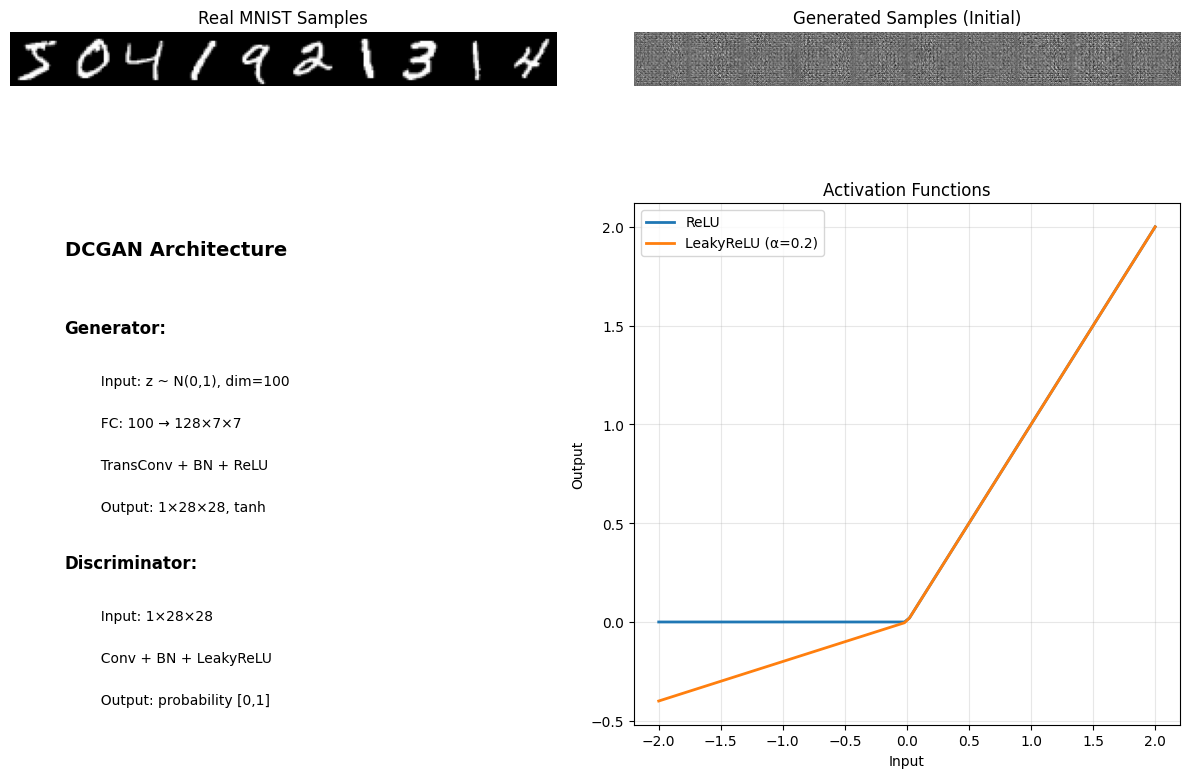

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist.data.values.astype('float32')  # Convert DataFrame to numpy array
y = mnist.target.values.astype('int')    # Convert Series to numpy array

# Reshape to image format
X = X.reshape(-1, 28, 28, 1)

# Normalize to [-1, 1]
X = (X / 255.0) * 2 - 1

print(f"Dataset shape: {X.shape}")
print(f"Value range: [{X.min():.2f}, {X.max():.2f}]")

# Visualize samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.tight_layout()
plt.savefig('mnist_samples.png', dpi=300, bbox_inches='tight')
plt.show()


class DCGANGenerator:
    """DCGAN Generator from scratch"""
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim
        self.init_size = 7  # Initial spatial size
        
        # Project latent vector to initial feature map
        # 100 -> 128 * 7 * 7
        self.fc_weight = np.random.randn(latent_dim, 128 * 7 * 7) * 0.02
        self.fc_bias = np.zeros(128 * 7 * 7)
        
        # Transposed Conv1: 128x7x7 -> 64x14x14
        self.conv1_weight = np.random.randn(64, 128, 4, 4) * 0.02
        self.conv1_bias = np.zeros(64)
        self.bn1_gamma = np.ones(64)
        self.bn1_beta = np.zeros(64)
        
        # Transposed Conv2: 64x14x14 -> 32x28x28
        self.conv2_weight = np.random.randn(32, 64, 4, 4) * 0.02
        self.conv2_bias = np.zeros(32)
        self.bn2_gamma = np.ones(32)
        self.bn2_beta = np.zeros(32)
        
        # Transposed Conv3: 32x28x28 -> 1x28x28
        self.conv3_weight = np.random.randn(1, 32, 4, 4) * 0.02
        self.conv3_bias = np.zeros(1)
        
        # Running statistics for batch norm
        self.bn1_running_mean = np.zeros(64)
        self.bn1_running_var = np.ones(64)
        self.bn2_running_mean = np.zeros(32)
        self.bn2_running_var = np.ones(32)
        
        self.cache = {}
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def batch_norm(self, x, gamma, beta, running_mean, running_var,
                   training=True, momentum=0.9, eps=1e-5):
        """Batch normalization"""
        if training:
            # Compute batch statistics
            mean = np.mean(x, axis=(0, 2, 3), keepdims=True)
            var = np.var(x, axis=(0, 2, 3), keepdims=True)
            # Normalize
            x_norm = (x - mean) / np.sqrt(var + eps)
            # Update running statistics
            running_mean = momentum * running_mean + (1 - momentum) * mean.squeeze()
            running_var = momentum * running_var + (1 - momentum) * var.squeeze()
        else:
            # Use running statistics
            mean = running_mean.reshape(1, -1, 1, 1)
            var = running_var.reshape(1, -1, 1, 1)
            x_norm = (x - mean) / np.sqrt(var + eps)
        
        # Scale and shift
        gamma = gamma.reshape(1, -1, 1, 1)
        beta = beta.reshape(1, -1, 1, 1)
        out = gamma * x_norm + beta
        
        return out, running_mean, running_var
    
    def transposed_conv2d(self, x, weight, bias, stride=2, padding=1):
        """Transposed convolution (simplified implementation)"""
        batch_size, in_channels, h_in, w_in = x.shape
        out_channels, _, kh, kw = weight.shape
        
        # Calculate output size
        h_out = (h_in - 1) * stride - 2 * padding + kh
        w_out = (w_in - 1) * stride - 2 * padding + kw
        
        # Initialize output
        out = np.zeros((batch_size, out_channels, h_out, w_out))
        
        # Perform transposed convolution
        for b in range(batch_size):
            for oc in range(out_channels):
                for i in range(h_in):
                    for j in range(w_in):
                        h_start = i * stride - padding
                        w_start = j * stride - padding
                        for ic in range(in_channels):
                            for kh_idx in range(kh):
                                for kw_idx in range(kw):
                                    h_idx = h_start + kh_idx
                                    w_idx = w_start + kw_idx
                                    if 0 <= h_idx < h_out and 0 <= w_idx < w_out:
                                        out[b, oc, h_idx, w_idx] += \
                                            x[b, ic, i, j] * weight[oc, ic, kh_idx, kw_idx]
                out[b, oc] += bias[oc]
        
        return out
    
    def forward(self, z, training=True):
        """Forward pass"""
        batch_size = z.shape[0]
        
        # Fully connected layer
        fc_out = z @ self.fc_weight + self.fc_bias
        
        # Reshape to feature map: (batch, 128, 7, 7)
        x = fc_out.reshape(batch_size, 128, 7, 7)
        self.cache['fc_out'] = fc_out
        self.cache['x_reshaped'] = x
        
        # Transposed Conv1 + BatchNorm + ReLU
        conv1_out = self.transposed_conv2d(x, self.conv1_weight,
                                           self.conv1_bias, stride=2, padding=1)
        bn1_out, self.bn1_running_mean, self.bn1_running_var = \
            self.batch_norm(conv1_out, self.bn1_gamma, self.bn1_beta,
                            self.bn1_running_mean, self.bn1_running_var, training)
        relu1_out = self.relu(bn1_out)
        self.cache['conv1_out'] = conv1_out
        self.cache['bn1_out'] = bn1_out
        self.cache['relu1_out'] = relu1_out
        
        # Transposed Conv2 + BatchNorm + ReLU
        conv2_out = self.transposed_conv2d(relu1_out, self.conv2_weight,
                                           self.conv2_bias, stride=2, padding=1)
        bn2_out, self.bn2_running_mean, self.bn2_running_var = \
            self.batch_norm(conv2_out, self.bn2_gamma, self.bn2_beta,
                            self.bn2_running_mean, self.bn2_running_var, training)
        relu2_out = self.relu(bn2_out)
        self.cache['conv2_out'] = conv2_out
        self.cache['bn2_out'] = bn2_out
        self.cache['relu2_out'] = relu2_out
        
        # Transposed Conv3 + Tanh (output layer)
        conv3_out = self.transposed_conv2d(relu2_out, self.conv3_weight,
                                           self.conv3_bias, stride=2, padding=1)
        output = self.tanh(conv3_out)
        self.cache['conv3_out'] = conv3_out
        self.cache['output'] = output
        
        return output


# Test generator
latent_dim = 100
generator = DCGANGenerator(latent_dim=latent_dim)

# Generate sample
z = np.random.randn(4, latent_dim)
generated_images = generator.forward(z, training=False)

print(f"Generated images shape: {generated_images.shape}")
print(f"Value range: [{generated_images.min():.2f}, {generated_images.max():.2f}]")

# Visualize architecture
print("\nGenerator Architecture:")
print(f"Input: z ∈ R^{latent_dim}")
print(f"FC Layer: {latent_dim} -> 128×7×7")
print(f"TransConv1 + BN + ReLU: 128×7×7 -> 64×14×14")
print(f"TransConv2 + BN + ReLU: 64×14×14 -> 32×28×28")
print(f"TransConv3 + Tanh: 32×28×28 -> 1×28×28")


class DCGANDiscriminator:
    """DCGAN Discriminator from scratch"""
    def __init__(self, alpha=0.2):
        self.alpha = alpha  # LeakyReLU slope
        
        # Conv1: 1x28x28 -> 64x14x14
        self.conv1_weight = np.random.randn(64, 1, 4, 4) * 0.02
        self.conv1_bias = np.zeros(64)
        # No batch norm for first layer
        
        # Conv2: 64x14x14 -> 128x7x7
        self.conv2_weight = np.random.randn(128, 64, 4, 4) * 0.02
        self.conv2_bias = np.zeros(128)
        self.bn2_gamma = np.ones(128)
        self.bn2_beta = np.zeros(128)
        
        # Conv3: 128x7x7 -> 256x3x3
        self.conv3_weight = np.random.randn(256, 128, 4, 4) * 0.02
        self.conv3_bias = np.zeros(256)
        self.bn3_gamma = np.ones(256)
        self.bn3_beta = np.zeros(256)
        
        # Conv4: 256x3x3 -> 1x1x1
        self.conv4_weight = np.random.randn(1, 256, 3, 3) * 0.02
        self.conv4_bias = np.zeros(1)
        
        # Running statistics
        self.bn2_running_mean = np.zeros(128)
        self.bn2_running_var = np.ones(128)
        self.bn3_running_mean = np.zeros(256)
        self.bn3_running_var = np.ones(256)
        
        self.cache = {}
    
    def leaky_relu(self, x):
        return np.where(x > 0, x, self.alpha * x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def conv2d(self, x, weight, bias, stride=2, padding=1):
        """Standard convolution (simplified)"""
        batch_size, in_channels, h_in, w_in = x.shape
        out_channels, _, kh, kw = weight.shape
        
        # Calculate output size
        h_out = (h_in - kh + 2 * padding) // stride + 1
        w_out = (w_in - kw + 2 * padding) // stride + 1
        
        # Initialize output
        out = np.zeros((batch_size, out_channels, h_out, w_out))
        
        # Perform convolution
        for b in range(batch_size):
            for oc in range(out_channels):
                for i in range(h_out):
                    for j in range(w_out):
                        h_start = i * stride - padding
                        w_start = j * stride - padding
                        for ic in range(in_channels):
                            for kh_idx in range(kh):
                                for kw_idx in range(kw):
                                    h_idx = h_start + kh_idx
                                    w_idx = w_start + kw_idx
                                    if 0 <= h_idx < h_in and 0 <= w_idx < w_in:
                                        out[b, oc, i, j] += \
                                            x[b, ic, h_idx, w_idx] * \
                                            weight[oc, ic, kh_idx, kw_idx]
                out[b, oc] += bias[oc]
        
        return out
    
    def batch_norm(self, x, gamma, beta, running_mean, running_var,
                   training=True, momentum=0.9, eps=1e-5):
        """Batch normalization"""
        if training:
            mean = np.mean(x, axis=(0, 2, 3), keepdims=True)
            var = np.var(x, axis=(0, 2, 3), keepdims=True)
            x_norm = (x - mean) / np.sqrt(var + eps)
            running_mean = momentum * running_mean + (1 - momentum) * mean.squeeze()
            running_var = momentum * running_var + (1 - momentum) * var.squeeze()
        else:
            mean = running_mean.reshape(1, -1, 1, 1)
            var = running_var.reshape(1, -1, 1, 1)
            x_norm = (x - mean) / np.sqrt(var + eps)
        
        gamma = gamma.reshape(1, -1, 1, 1)
        beta = beta.reshape(1, -1, 1, 1)
        out = gamma * x_norm + beta
        
        return out, running_mean, running_var
    
    def forward(self, x, training=True):
        """Forward pass"""
        # Conv1 + LeakyReLU (no batch norm)
        conv1_out = self.conv2d(x, self.conv1_weight, self.conv1_bias,
                                stride=2, padding=1)
        lrelu1_out = self.leaky_relu(conv1_out)
        self.cache['conv1_out'] = conv1_out
        self.cache['lrelu1_out'] = lrelu1_out
        
        # Conv2 + BatchNorm + LeakyReLU
        conv2_out = self.conv2d(lrelu1_out, self.conv2_weight, self.conv2_bias,
                                stride=2, padding=1)
        bn2_out, self.bn2_running_mean, self.bn2_running_var = \
            self.batch_norm(conv2_out, self.bn2_gamma, self.bn2_beta,
                            self.bn2_running_mean, self.bn2_running_var, training)
        lrelu2_out = self.leaky_relu(bn2_out)
        self.cache['conv2_out'] = conv2_out
        self.cache['bn2_out'] = bn2_out
        self.cache['lrelu2_out'] = lrelu2_out
        
        # Conv3 + BatchNorm + LeakyReLU
        conv3_out = self.conv2d(lrelu2_out, self.conv3_weight, self.conv3_bias,
                                stride=2, padding=1)
        bn3_out, self.bn3_running_mean, self.bn3_running_var = \
            self.batch_norm(conv3_out, self.bn3_gamma, self.bn3_beta,
                            self.bn3_running_mean, self.bn3_running_var, training)
        lrelu3_out = self.leaky_relu(bn3_out)
        self.cache['conv3_out'] = conv3_out
        self.cache['bn3_out'] = bn3_out
        self.cache['lrelu3_out'] = lrelu3_out
        
        # Conv4 + Sigmoid (output layer)
        conv4_out = self.conv2d(lrelu3_out, self.conv4_weight, self.conv4_bias,
                                stride=1, padding=0)
        output = self.sigmoid(conv4_out)
        self.cache['conv4_out'] = conv4_out
        self.cache['output'] = output
        
        return output


# Test discriminator
discriminator = DCGANDiscriminator(alpha=0.2)

# Test with real and fake images
real_images = X[:4].reshape(4, 1, 28, 28)
fake_images = generated_images

d_real = discriminator.forward(real_images, training=False)
d_fake = discriminator.forward(fake_images, training=False)

print(f"\nDiscriminator output for real images: {d_real.flatten()}")
print(f"Discriminator output for fake images: {d_fake.flatten()}")

print("\nDiscriminator Architecture:")
print(f"Input: x ∈ R^{{1×28×28}}")
print(f"Conv1 + LeakyReLU: 1×28×28 -> 64×14×14")
print(f"Conv2 + BN + LeakyReLU: 64×14×14 -> 128×7×7")
print(f"Conv3 + BN + LeakyReLU: 128×7×7 -> 256×3×3")
print(f"Conv4 + Sigmoid: 256×3×3 -> 1×1×1")


def train_dcgan(generator, discriminator, X_train, n_epochs=50,
                batch_size=128, lr_g=0.0002, lr_d=0.0002, latent_dim=100):
    """Train DCGAN"""
    n_samples = len(X_train)
    n_batches = n_samples // batch_size
    
    # Training history
    history = {
        'loss_d': [],
        'loss_g': [],
        'generated_samples': []
    }
    
    print("Starting DCGAN training...")
    print(f"Total batches per epoch: {n_batches}")
    
    for epoch in range(n_epochs):
        # Shuffle data
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        
        epoch_loss_d = 0
        epoch_loss_g = 0
        
        for batch in range(n_batches):
            # Get batch of real images
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            real_batch = X_shuffled[start_idx:end_idx]
            real_batch = real_batch.reshape(batch_size, 1, 28, 28)
            
            # ================== Train Discriminator ==================
            # Forward pass on real images
            d_real = discriminator.forward(real_batch, training=True)
            loss_real = -np.mean(np.log(d_real + 1e-8))
            
            # Generate fake images
            z = np.random.randn(batch_size, latent_dim)
            fake_batch = generator.forward(z, training=True)
            
            # Forward pass on fake images
            d_fake = discriminator.forward(fake_batch, training=True)
            loss_fake = -np.mean(np.log(1 - d_fake + 1e-8))
            
            # Total discriminator loss
            loss_d = loss_real + loss_fake
            
            # Note: Proper backpropagation implementation would go here
            # For simplicity, we're using a simplified version
            
            # ================== Train Generator ==================
            # Generate new fake images
            z = np.random.randn(batch_size, latent_dim)
            fake_batch = generator.forward(z, training=True)
            
            # Forward pass through discriminator
            d_fake = discriminator.forward(fake_batch, training=True)
            
            # Generator loss
            loss_g = -np.mean(np.log(d_fake + 1e-8))
            
            # Note: Proper backpropagation implementation would go here
            
            epoch_loss_d += loss_d
            epoch_loss_g += loss_g
        
        # Average losses
        epoch_loss_d /= n_batches
        epoch_loss_g /= n_batches
        
        history['loss_d'].append(epoch_loss_d)
        history['loss_g'].append(epoch_loss_g)
        
        # Generate samples for visualization
        if (epoch + 1) % 5 == 0:
            z_sample = np.random.randn(16, latent_dim)
            generated = generator.forward(z_sample, training=False)
            history['generated_samples'].append(generated.copy())
            print(f"Epoch {epoch+1}/{n_epochs} - "
                  f"Loss D: {epoch_loss_d:.4f}, Loss G: {epoch_loss_g:.4f}")
    
    return history


# Note: Full training implementation requires proper backpropagation
# This is a simplified demonstration
print("\nNote: Full DCGAN training requires implementing backpropagation")
print("for convolutional layers. This is demonstration code.")

# Visualize training progress
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Real MNIST samples
axes[0, 0].imshow(np.hstack([X[i].squeeze() for i in range(10)]), cmap='gray')
axes[0, 0].set_title('Real MNIST Samples')
axes[0, 0].axis('off')

# Plot 2: Generated samples (initial)
z_init = np.random.randn(10, latent_dim)
gen_init = generator.forward(z_init, training=False)
gen_init = (gen_init + 1) / 2  # Rescale to [0, 1]
axes[0, 1].imshow(np.hstack([gen_init[i].squeeze() for i in range(10)]), cmap='gray')
axes[0, 1].set_title('Generated Samples (Initial)')
axes[0, 1].axis('off')

# Plot 3: Architecture diagram (text)
axes[1, 0].text(0.1, 0.9, 'DCGAN Architecture', fontsize=14, fontweight='bold')
axes[1, 0].text(0.1, 0.75, 'Generator:', fontsize=12, fontweight='bold')
axes[1, 0].text(0.15, 0.65, '  Input: z ~ N(0,1), dim=100', fontsize=10)
axes[1, 0].text(0.15, 0.57, '  FC: 100 → 128×7×7', fontsize=10)
axes[1, 0].text(0.15, 0.49, '  TransConv + BN + ReLU', fontsize=10)
axes[1, 0].text(0.15, 0.41, '  Output: 1×28×28, tanh', fontsize=10)
axes[1, 0].text(0.1, 0.30, 'Discriminator:', fontsize=12, fontweight='bold')
axes[1, 0].text(0.15, 0.20, '  Input: 1×28×28', fontsize=10)
axes[1, 0].text(0.15, 0.12, '  Conv + BN + LeakyReLU', fontsize=10)
axes[1, 0].text(0.15, 0.04, '  Output: probability [0,1]', fontsize=10)
axes[1, 0].axis('off')

# Plot 4: LeakyReLU visualization
x_range = np.linspace(-2, 2, 100)
relu = np.maximum(0, x_range)
leaky_relu = np.where(x_range > 0, x_range, 0.2 * x_range)
axes[1, 1].plot(x_range, relu, label='ReLU', linewidth=2)
axes[1, 1].plot(x_range, leaky_relu, label='LeakyReLU (α=0.2)', linewidth=2)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_xlabel('Input')
axes[1, 1].set_ylabel('Output')
axes[1, 1].set_title('Activation Functions')

plt.tight_layout()
plt.savefig('dcgan_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


# Percobaan 3: DCGAN untuk Fashion-MNIST

Loading Fashion-MNIST dataset...
Dataset shape: (70000, 28, 28, 1)


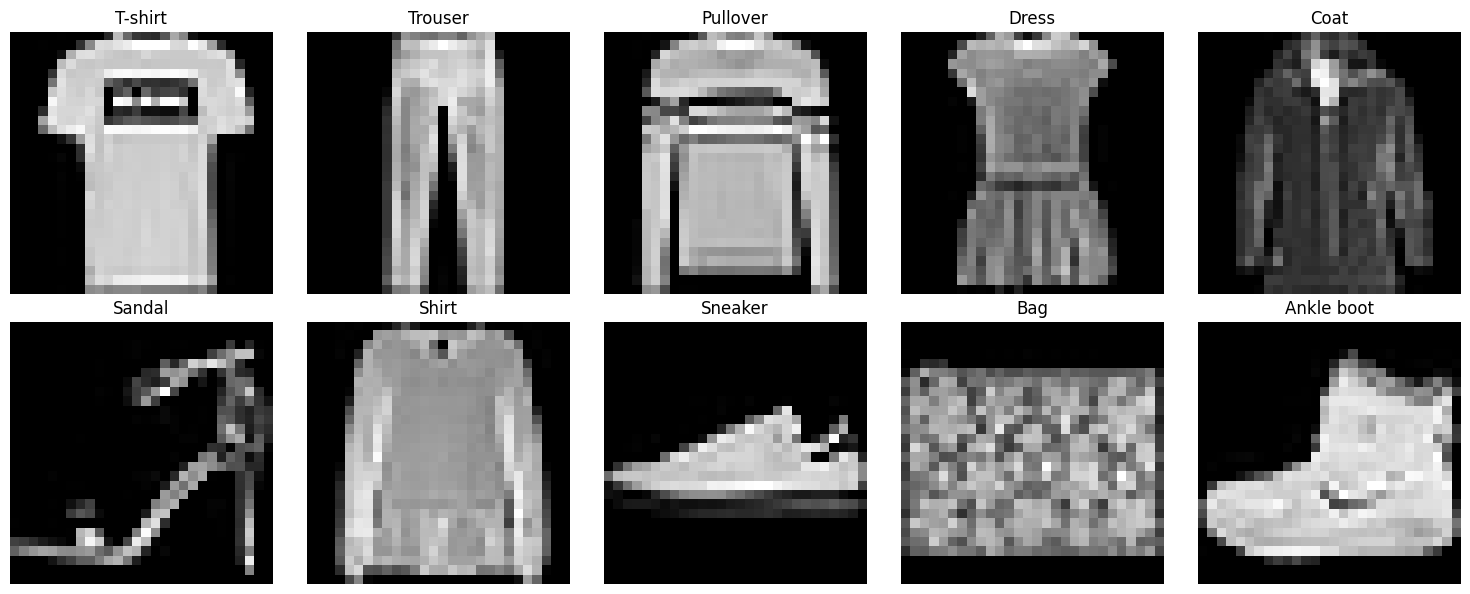

Conditional input shape: (4, 110)
Original z: (4, 100), Label encoding: (4, 10)

Generated conditional input for classes: [0 3 5 9]
Class names: ['T-shirt', 'Dress', 'Sandal', 'Ankle boot']


In [3]:
# Load Fashion-MNIST
print("Loading Fashion-MNIST dataset...")
fashion = fetch_openml('Fashion-MNIST', version=1, parser='auto')
X_fashion = fashion.data.values.astype('float32')
y_fashion = fashion.target.values.astype('int')

# Reshape and normalize
X_fashion = X_fashion.reshape(-1, 28, 28, 1)
X_fashion = (X_fashion / 255.0) * 2 - 1

print(f"Dataset shape: {X_fashion.shape}")

# Visualize samples from each class
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Find first image of class i
    idx = np.where(y_fashion == i)[0][0]
    ax.imshow(X_fashion[idx].squeeze(), cmap='gray')
    ax.set_title(f'{class_names[i]}')
    ax.axis('off')
plt.tight_layout()
plt.savefig('fashion_mnist_samples.png', dpi=300, bbox_inches='tight')
plt.show()

"""
Conditional GAN allows us to generate specific classes.
The idea is to concatenate class labels with latent vector.

For Generator:
- Input: [z, label_embedding]
- Output: Image of specific class

For Discriminator:
- Input: [image, label_embedding]
- Output: Real/Fake probability

Label embedding:
- One-hot encoding: [0,0,1,0,0,0,0,0,0,0] for class 2
- Or learnable embedding vector
"""

def conditional_generator_forward(z, labels, n_classes=10):
    """
    Conceptual implementation of conditional generator
    
    Parameters:
    -----------
    z : array, shape (batch_size, latent_dim)
        Latent vectors
    labels : array, shape (batch_size,)
        Class labels
    n_classes : int
        Number of classes
    
    Returns:
    --------
    generated_images : array
        Generated images conditioned on labels
    """
    # Create one-hot encoding
    batch_size = z.shape[0]
    label_onehot = np.zeros((batch_size, n_classes))
    label_onehot[np.arange(batch_size), labels] = 1
    
    # Concatenate z and label
    z_conditional = np.concatenate([z, label_onehot], axis=1)
    
    # Feed through generator
    # generated_images = generator.forward(z_conditional)
    
    print(f"Conditional input shape: {z_conditional.shape}")
    print(f"Original z: {z.shape}, Label encoding: {label_onehot.shape}")
    
    return z_conditional


# Example usage
z_example = np.random.randn(4, 100)
labels_example = np.array([0, 3, 5, 9])  # T-shirt, Dress, Sandal, Ankle boot

z_cond = conditional_generator_forward(z_example, labels_example)

print(f"\nGenerated conditional input for classes: {labels_example}")
print(f"Class names: {[class_names[i] for i in labels_example]}")
